# DeepSleep visualizations

## import

In [5]:
import numpy as np
import pickle
import seaborn as sns
import pandas as pd
import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt
% matplotlib inline

from keras.applications import VGG16
from keras.models import Sequential
from keras import activations
from vis.utils import utils
from keras.utils.data_utils import get_file
from vis.visualization import visualize_cam, visualize_saliency, overlay
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed, Bidirectional

## Load data

Spectrograms:

In [6]:
from skimage import io

def load_spectrograms(subject_id, night_id):
    labels = np.loadtxt(impath +'sub'+str(subject_id)+'_n'+str(night_id)+'_img_'+sensors+'/labels.txt',dtype=bytes).astype(str)
    num_images = np.size(labels)
    
    targets = np.zeros((num_images), dtype='int')
    targets[:]=-1    
    targets[labels=='W'] = 0
    targets[labels=='1'] = 1
    targets[labels=='2'] = 2
    targets[labels=='3'] = 3
    targets[labels=='4'] = 3
    targets[labels=='R'] = 4
    
    if max(targets)>4:
        print('Error in reading targets')
    
    targets = targets[targets!=-1]
    num_images = np.size(targets)
    
    inputs = np.zeros((num_images,224,224,3),dtype='uint8')

    for idx in range(1,num_images+1):    
        rawim = io.imread(impath + 'sub'+str(subject_id)+'_n'+str(night_id)+'_img_'+sensors+'/img_'+ np.str(idx) +'.png')
        rawim = rawim[:,:,0:3]
        
        h, w, _ = rawim.shape
        if not (h==224 and w==224):
            rawim = skimage.transform.resize(rawim, (224, 224), preserve_range=True)
               
        inputs[idx-1,:,:,:]=rawim
    
    return inputs, targets

In [7]:
impath = "./step1_f4_testsubs/"
sensors = 'fpz'

# subject 2 (test subject)
sub2_inputs_night1, sub2_targets_night1  = load_spectrograms(2,1)
sub2_inputs_night2, sub2_targets_night2  = load_spectrograms(2,2)

sub2_inputs = np.concatenate((sub2_inputs_night1, sub2_inputs_night2),axis=0)
sub2_targets = np.concatenate((sub2_targets_night1, sub2_targets_night2),axis=0)

# subject 11
sub11_inputs_night1, sub11_targets_night1 = load_spectrograms(11,1)
sub11_inputs_night2, sub11_targets_night2 = load_spectrograms(11,2)

sub11_inputs = np.concatenate((sub11_inputs_night1, sub11_inputs_night2),axis=0)
sub11_targets = np.concatenate((sub11_targets_night1, sub11_targets_night2),axis=0)

# Load models

(Remember to disable dropout for saliency visualizations!)

In [8]:
import keras.initializers as initializers
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers
from keras.optimizers import Adam

num_dense = 4096
num_classes = 5

def build_model(init_seed=None):
    # CONVOLUTIONAL LAYERS: use the pretrained weights from ImageNet
    base_model = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
    
    # TOP LAYERS: Trainable dense layers with random initialization
    dense_model = Sequential()
    # Input layer
    dense_model.add(Flatten(input_shape=base_model.output_shape[1:], name="Flatten"))
    # FC6
    dense_model.add(Dense(num_dense, activation='relu', kernel_initializer=initializers.glorot_normal(seed=init_seed), kernel_regularizer=regularizers.l2(0.01), name="Dense1"))
    # FC6 Dropout
#     dense_model.add(Dropout(rate=0.5, name="Dropout1"))
    # FC7
    dense_model.add(Dense(num_dense, activation='relu', kernel_initializer=initializers.glorot_normal(seed=init_seed), kernel_regularizer=regularizers.l2(0.01), name="Dense2"))
    # FC7 Dropout
#     dense_model.add(Dropout(rate=0.5, name="Dropout2"))
    # Softmax
    dense_model.add(Dense(num_classes, activation='softmax', kernel_initializer=initializers.glorot_normal(seed=init_seed), kernel_regularizer=regularizers.l2(0.01), name="Dense3"))

    # CREATE THE FULL MODEL (stack the dense layers on the convolutional layers)
    model = Sequential()
    # Add convolutional layers
    for layer in base_model.layers:
        model.add(layer)
    # Fix weights in the convolutional layers
    for layer in model.layers:
        layer.trainable = False
    # Add fully conncected layers
    for layer in dense_model.layers:
        model.add(layer)
    
    
    # COMPILE THE MODEL
    # Optimizer (can't figure out what learning rate Albert used)
    adam = Adam(lr = 0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

    return model


cnn = build_model(3)
cnn.load_weights('./weights/CNN_weights_fold4.hdf5')

In [9]:
timesteps=5
droprate=0.5


wpath = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
wpath_notop = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    wpath,
                                    cache_subdir='models',
                                    file_hash='64373286793e3c8b2b4e3219cbf3544b')
weights_path_no_top = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    wpath_notop,
                                    cache_subdir='models',
                                    file_hash='6d6bbae143d832006294945121d1f1fc')


# CNN (TimeDistributed VGG16)
vgg16 = Sequential()

# Block 1
vgg16.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', trainable=False), name='block1_tdist_conv1', input_shape=(timesteps, 224, 224, 3))) # timesteps x 224x224x64
vgg16.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', trainable=False), name='block1_tdist_conv2')) # timesteps x 224x224x64
vgg16.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='block1_tdist_pool')) # timesteps x 112x112x64

# Block 2
vgg16.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same', trainable=False), name='block2_tdist_conv1')) # timesteps x 112x112x128
vgg16.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same', trainable=False), name='block2_tdist_conv2')) # timesteps x 112x112x128
vgg16.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='block2_tdist_pool')) # timesteps x 56x56x128

# Block 3
vgg16.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same', trainable=False), name='block3_tdist_conv1')) # timesteps x 56x56x256
vgg16.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same', trainable=False), name='block3_tdist_conv2')) # timesteps x 56x56x256
vgg16.add(TimeDistributed(Conv2D(256, (3, 3), activation='relu', padding='same', trainable=False), name='block3_tdist_conv3')) # timesteps x 56x56x256
vgg16.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='block3_tdist_pool')) # timesteps x 28x28x256

# Block 4
vgg16.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', trainable=False), name='block4_tdist_conv1')) # timesteps x 28x28x512
vgg16.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', trainable=False), name='block4_tdist_conv2')) # timesteps x 28x28x512
vgg16.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', trainable=False), name='block4_tdist_conv3')) # timesteps x 28x28x512
vgg16.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='block4_tdist_pool')) # timesteps x 14x14x512

# Block 5
vgg16.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', trainable=False), name='block5_tdist_conv1')) # timesteps x 14x14x512
vgg16.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', trainable=False), name='block5_tdist_conv2')) # timesteps x 14x14x512
vgg16.add(TimeDistributed(Conv2D(512, (3, 3), activation='relu', padding='same', trainable=False), name='block5_tdist_conv3')) # timesteps x 14x14x512
vgg16.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)), name='block5_tdist_pool')) # timesteps x 7x7x512

# RNN
rnn = Sequential()
rnn.add(TimeDistributed(Flatten(), input_shape=vgg16.output_shape[1:], name="block7_tdist_flatten")) # timesteps x 25088; skip this line if including block 6
rnn.add(Bidirectional(LSTM(32, return_sequences=True), name="block7_bidir_lstm1")) # timesteps x (2x32)
# rnn.add(Dropout(rate=droprate, name="block7_dropout1")) # timesteps x (2x32)
rnn.add(Bidirectional(LSTM(64, return_sequences=True), name="block7_bidir_lstm2")) # timesteps x (2x64)
# rnn.add(Dropout(rate=droprate, name="block7_dropout2")) # timesteps x (2x64)
rnn.add(LSTM(num_classes, activation='softmax', return_sequences=False, name="block7_lstm3")) # 1 x num_classes

# Combine to LCRN
lcrn = Sequential()
# add VGG 16 base layers
for layer in vgg16.layers:
    lcrn.add(layer)
# load VGG16 imagenet weights
lcrn.load_weights(weights_path_no_top) # only base layers
# add rnn layers
for layer in rnn.layers:
    lcrn.add(layer)


# COMPILE THE MODEL
# Optimizer
adam = Adam(lr = 0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
lcrn.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
lcrn.load_weights("weights/RNN_5steps_weights_fold4.hdf5")

In [10]:
lcrn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_tdist_conv1 (TimeDist (None, 5, 224, 224, 64)   1792      
_________________________________________________________________
block1_tdist_conv2 (TimeDist (None, 5, 224, 224, 64)   36928     
_________________________________________________________________
block1_tdist_pool (TimeDistr (None, 5, 112, 112, 64)   0         
_________________________________________________________________
block2_tdist_conv1 (TimeDist (None, 5, 112, 112, 128)  73856     
_________________________________________________________________
block2_tdist_conv2 (TimeDist (None, 5, 112, 112, 128)  147584    
_________________________________________________________________
block2_tdist_pool (TimeDistr (None, 5, 56, 56, 128)    0         
_________________________________________________________________
block3_tdist_conv1 (TimeDist (None, 5, 56, 56, 256)    295168    
__________

----

# Prediction accuracy over time

Load CNN predictions

In [6]:
with open('../predictions/cnn_preds2.pickle', 'rb') as f:
    cnn_preds = pickle.load(f)
cnn_preds2 = np.argmax(cnn_preds, axis=1)

with open('../predictions/cnn_preds11.pickle', 'rb') as f:
    cnn_preds = pickle.load(f)
cnn_preds11 = np.argmax(cnn_preds, axis=1)

Load CRNN (timesteps=5) predictions

In [7]:
with open('../predictions/preds2.pickle', 'rb') as f:
    preds2 = pickle.load(f)
rnn_preds2 = preds2['y_pred']
labels2 = preds2['y']
    
with open('../predictions/preds11.pickle', 'rb') as f:
    preds11 = pickle.load(f)
rnn_preds11 = preds11['y_pred']
labels11 = preds11['y']

In [8]:
def predplot(preds, labels, cutoff, title=None):
    # load data
    y = labels
    y_ = preds

    df = pd.DataFrame()
    df['interval'] = range(len(y))
    df['label'] = y
    df['prediction'] = y_
    df['correct'] = df['label'] == df['prediction']
    df['height'] = 1
    df.head()

    # group data
    w = df.loc[df['label']==0]
    n1 = df.loc[df['label']==1]
    n2 = df.loc[df['label']==2]
    n3 = df.loc[df['label']==3]
    r = df.loc[df['label']==4]
    
    w_pred = df.loc[df['prediction']==0]
    n1_pred = df.loc[df['prediction']==1]
    n2_pred = df.loc[df['prediction']==2]
    n3_pred = df.loc[df['prediction']==3]
    r_pred = df.loc[df['prediction']==4]
    
    hit = df.loc[df['correct']==True]
    miss = df.loc[df['correct']==False]

    cutoff = cutoff # cutoff btwn night 1 & 2 (subj2 = 1021; subj11 = 1038)
    n1_hours = int(np.ceil((cutoff)*30/(60*60)))
    n2_hours = int(np.ceil((len(labels) - cutoff)*30/(60*60)))

    plt.figure(figsize=(16,10))
    plt.subplot(3,2,1)
    plt.bar(w[w.index < cutoff].index, 5-w[w.index < cutoff]["label"], label="W", width=1.0)
    plt.bar(n1[n1.index < cutoff].index, 5-n1[n1.index < cutoff]["label"], label="N1", width=1.0)
    plt.bar(n2[n2.index < cutoff].index, 5-n2[n2.index < cutoff]["label"], label="N2", width=1.0)
    plt.bar(n3[n3.index < cutoff].index, 5-n3[n3.index < cutoff]["label"], label="N3", width=1.0)
    plt.bar(r[r.index < cutoff].index, 5-r[r.index < cutoff]["label"], label="R", width=1.0)
    plt.legend(loc="upper center", bbox_to_anchor=(1, 1.15), ncol=5)
    plt.xticks([])
    plt.yticks([1,2,3,4,5], ["REM", "N1", "N2", "N3", "Awake"])
    plt.ylabel("Actual Sleep Stage")
    # plt.ylabel("Actual Sleep Stage", rotation=0, labelpad=60)
    plt.title("Night 1", fontsize=14)

    plt.subplot(3,2,2)
    plt.bar(w[w.index >= cutoff].index, 5-w[w.index >= cutoff]["label"], label="W", width=1.0)
    plt.bar(n1[n1.index >= cutoff].index, 5-n1[n1.index >= cutoff]["label"], label="N1", width=1.0)
    plt.bar(n2[n2.index >= cutoff].index, 5-n2[n2.index >= cutoff]["label"], label="N2", width=1.0)
    plt.bar(n3[n3.index >= cutoff].index, 5-n3[n3.index >= cutoff]["label"], label="N3", width=1.0)
    plt.bar(r[r.index >= cutoff].index, 5-r[r.index >= cutoff]["label"], label="R", width=1.0)
    sns.despine(left=True, right=True, bottom=True)
    plt.xticks([])
    plt.yticks([])
    plt.title("Night 2", fontsize=14)

    plt.subplot(3,2,3)
    plt.bar(w_pred[w_pred.index < cutoff].index, 5-w_pred[w_pred.index < cutoff]["prediction"], label="W", width=1.0)
    plt.bar(n1_pred[n1_pred.index < cutoff].index, 5-n1_pred[n1_pred.index < cutoff]["prediction"], label="N1", width=1.0)
    plt.bar(n2_pred[n2_pred.index < cutoff].index, 5-n2_pred[n2_pred.index < cutoff]["prediction"], label="N2", width=1.0)
    plt.bar(n3_pred[n3_pred.index < cutoff].index, 5-n3_pred[n3_pred.index < cutoff]["prediction"], label="N3", width=1.0)
    plt.bar(r_pred[r_pred.index < cutoff].index, 5-r_pred[r_pred.index < cutoff]["prediction"], label="R", width=1.0)
    sns.despine(left=True, right=True, bottom=True)
    plt.xticks([])
    plt.yticks([1,2,3,4,5], ["REM", "N1", "N2", "N3", "Awake"])
    plt.ylabel("Predicted Sleep Stage")
    # plt.ylabel("Predicted Sleep Stage", rotation=0, labelpad=50)

    plt.subplot(3,2,4)
    plt.bar(w_pred[w_pred.index >= cutoff].index, 5-w_pred[w_pred.index >= cutoff]["prediction"], label="W", width=1.0)
    plt.bar(n1_pred[n1_pred.index >= cutoff].index, 5-n1_pred[n1_pred.index >= cutoff]["prediction"], label="N1", width=1.0)
    plt.bar(n2_pred[n2_pred.index >= cutoff].index, 5-n2_pred[n2_pred.index >= cutoff]["prediction"], label="N2", width=1.0)
    plt.bar(n3_pred[n3_pred.index >= cutoff].index, 5-n3_pred[n3_pred.index >= cutoff]["prediction"], label="N3", width=1.0)
    plt.bar(r_pred[r_pred.index >= cutoff].index, 5-r_pred[r_pred.index >= cutoff]["prediction"], label="R", width=1.0)
    sns.despine(left=True, right=True, bottom=True)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,2,5)
    plt.bar(hit[hit.index < cutoff].index, hit[hit.index < cutoff]["height"], label="Hit", color='tab:green', width=1.0)
    plt.bar(miss[miss.index < cutoff].index, miss[miss.index < cutoff]["height"], label="Miss", color='tab:red', width=1.0)
    sns.despine(left=True, right=True, bottom=True)
    plt.xticks([(i*60*60)/30 for i in range(n1_hours)], [str(i) for i in range(n1_hours)])
    plt.yticks([])
    plt.legend(loc="center left", bbox_to_anchor=(-0.08, 0.5), markerfirst=False, frameon=False)
    plt.xlabel("Time (hours)")
    plt.ylabel("Classification Match", labelpad=40)
    # plt.ylabel("Classification Match", rotation=0, labelpad=90)

    plt.subplot(3,2,6)
    plt.bar(hit[hit.index >= cutoff].index, hit[hit.index >= cutoff]["height"], label="Hit", color='tab:green', width=1.0)
    plt.bar(miss[miss.index >= cutoff].index, miss[miss.index >= cutoff]["height"], label="Miss", color='tab:red', width=1.0)
    sns.despine(left=True, right=True, bottom=True)
    plt.xticks([cutoff+(i*60*60)/30 for i in range(n2_hours)], [str(i) for i in range(n2_hours)])
    plt.yticks([])
    plt.xlabel("Time (hours)")

    plt.tight_layout()
    
    if title:
        plt.savefig(title)

### Subject 11

CNN performance on subject 11

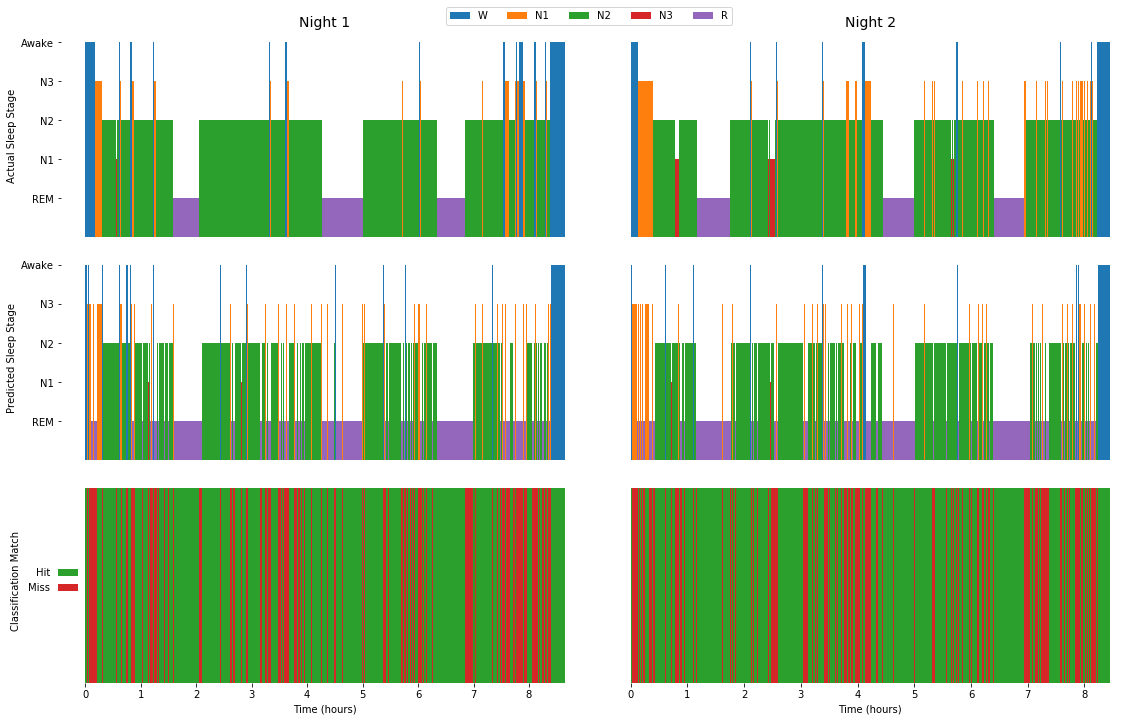

In [9]:
predplot(cnn_preds11, labels11, 1038)

CRNN5 performance on subject 11

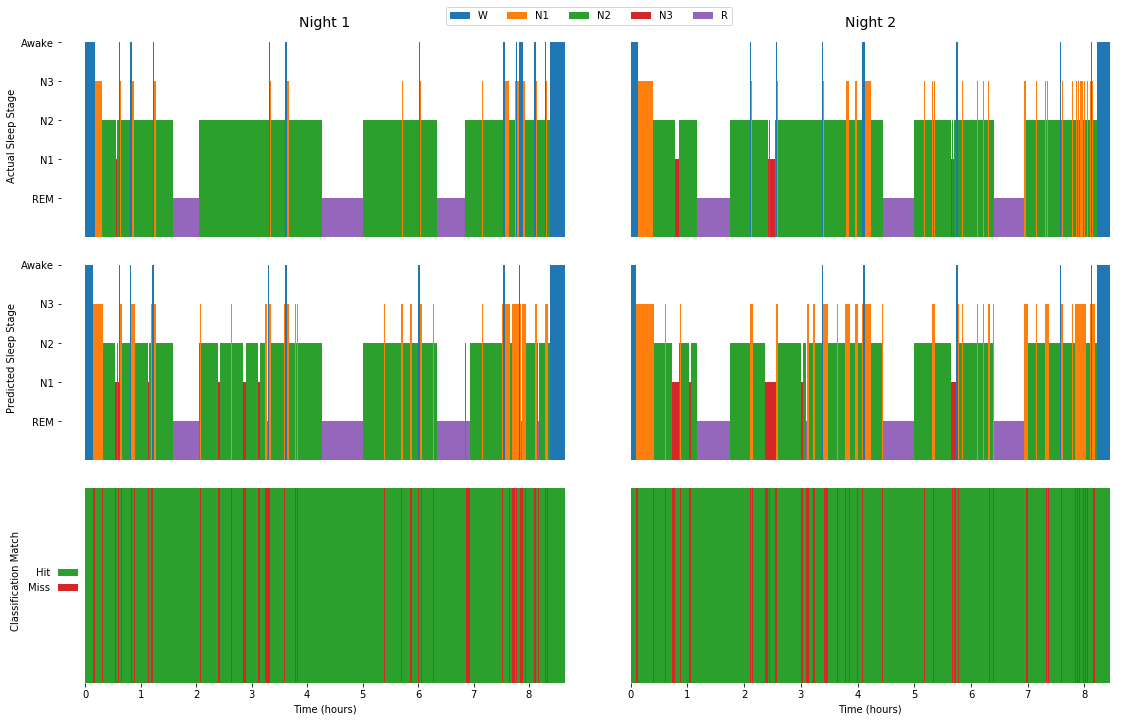

In [10]:
predplot(rnn_preds11, labels11, 1038)

### Subject 2

CNN performance on subject 2

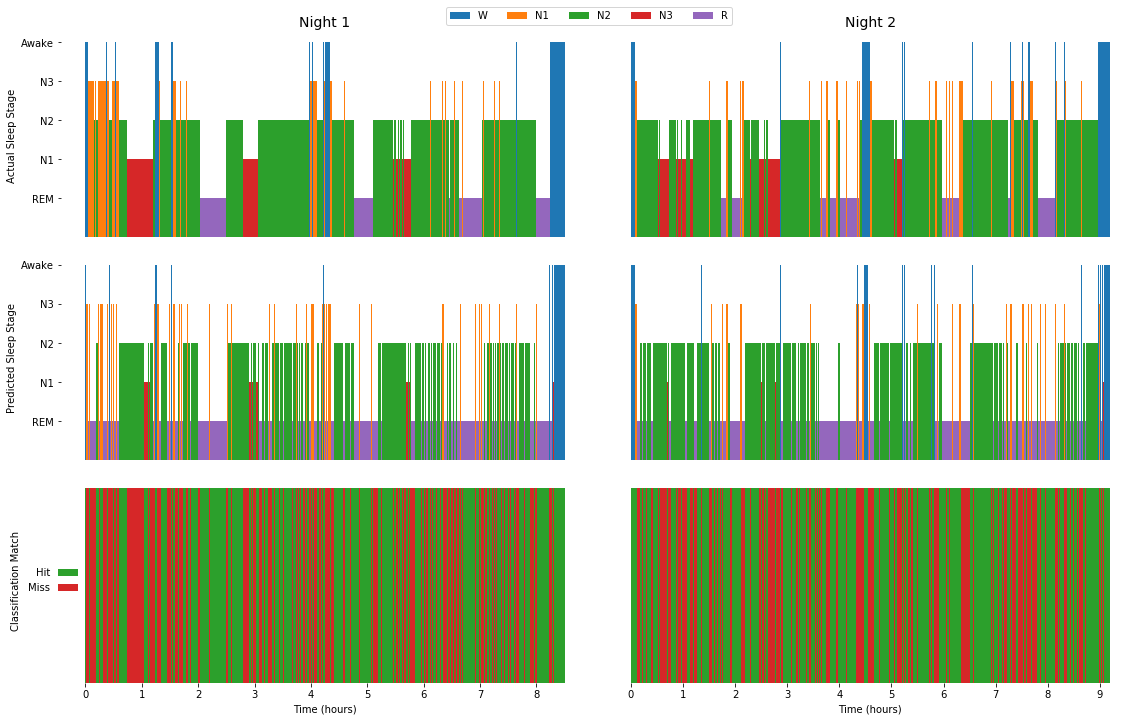

In [11]:
predplot(cnn_preds2, labels2, 1021)

CRNN5 performance on subject 2

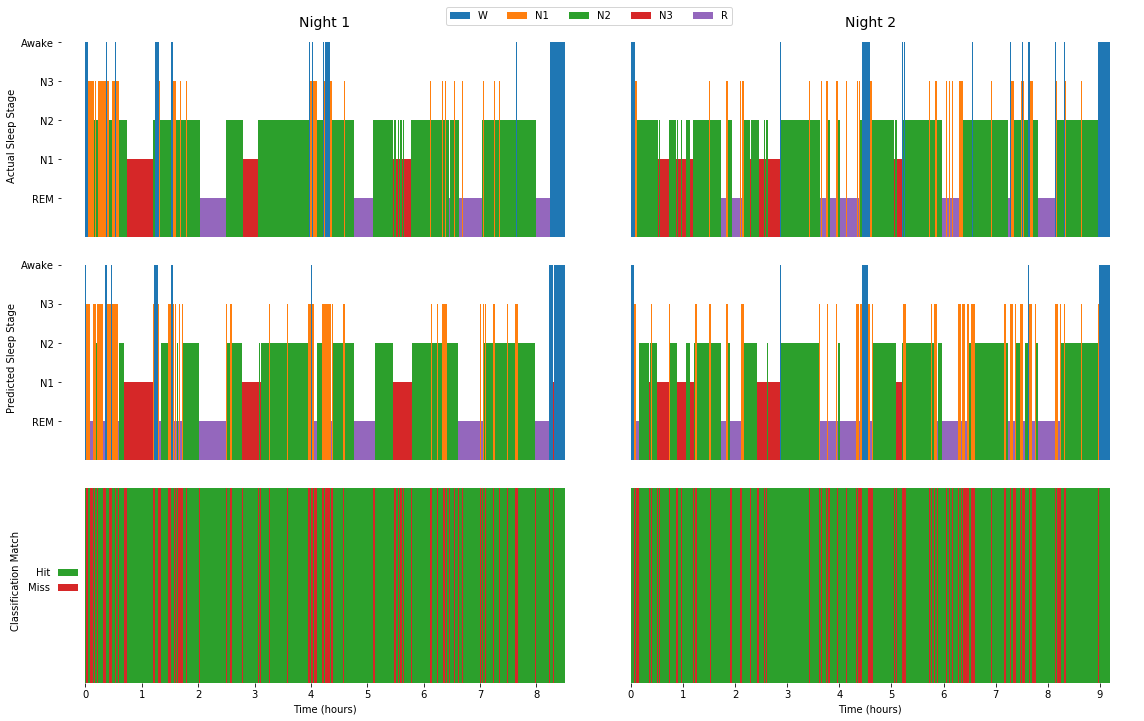

In [12]:
predplot(rnn_preds2, labels2, 1021)

----

# Sensitivity analysis

# PLAN

- Load prediction pickle for CRNN5
- Compute predictions for CNN
- Find images where CNN fails, but CRNN5 succeeds
- Plot saliency maps for each model on the found images

## Find case example

In [13]:
df = pd.DataFrame()
df["class"] = labels11
df["cnn"] = cnn_preds11
df["rnn"] = rnn_preds11
df = df[:1038] # look only at 1st night
df.head()

,class,cnn,rnn
0,0,0,0
1,0,0,0
2,0,0,0
3,0,1,0
4,0,0,0


In [14]:
# cases where class is N1 and RNN predicts N1, but CNN predicts something else
# df.loc[(df["class"] == 1) & (df["cnn"] != 1) & (df["rnn"] == 1)][-15:]

Case for sensitivity analysis:

In [15]:
df[950:957]

,class,cnn,rnn
950,1,4,1
951,1,4,1
952,1,1,1
953,2,4,1
954,2,4,1
955,2,1,2
956,2,4,2


## Saliency mapping

In [16]:
def findimgs(searchkey):
    files11 = sorted(glob.glob("../databatches5/sub11_batch?.pickle"))
    files11 += sorted(glob.glob("../databatches5/sub11_batch??.pickle"))
    files11 += sorted(glob.glob("../databatches5/sub11_batch???.pickle"))
    files11 += sorted(glob.glob("../databatches5/sub11_batch????.pickle"))

    count = -1
    imgs = []
    tgts = []
    for idx, batch in enumerate(files11):
        with open(batch, 'rb') as f:
            data = pickle.load(f)
        for i, img in enumerate(data[0]):
            count += 1
            if count+2 == searchkey: # t-2
                imgs.append(img)
                tgts.append(data[1][i])
            elif count+1 == searchkey: # t-1
                imgs.append(img)
                tgts.append(data[1][i])
            elif count == searchkey: # t0
                imgs.append(img)
                tgts.append(data[1][i])
            elif count-1 == searchkey: # t+1
                imgs.append(img)
                tgts.append(data[1][i])
            elif count-2 == searchkey: # t+2
                imgs.append(img)
                tgts.append(data[1][i])

    imgs = np.array(imgs)[2] # get batch with target image centered
    tgts = np.argmax(np.array(tgts), axis=1)
    print("Real labels:", tgts)
    
    return imgs, tgts

CNN

In [77]:
def cnnPredGrads(cnn, imgs):
    # find output layer
    layer_idx = utils.find_layer_idx(cnn, 'Dense3')

    # calc preds for input image
    cnn.layers[layer_idx].activation = activations.softmax # use softmax for preds
    cnn = utils.apply_modifications(cnn)
    cnn_preds = cnn.predict(np.expand_dims(imgs[2], axis=0))
    cnn_pred = np.argmax(cnn_preds)
    print("CNN pred:", cnn_pred)
    
    # modify cnn softmax to linear
    cnn.layers[layer_idx].activation = activations.linear
    cnn = utils.apply_modifications(cnn)

    # find grads wrt input image
    cnn_grads = visualize_saliency(cnn, layer_idx, filter_indices=cnn_pred,
                                   seed_input=imgs[2], backprop_modifier='guided')
    return cnn_pred, cnn_grads

CRNN

In [78]:
def rnnPredGrads(lcrn, imgs):
    # find output layer
    layer_idx = utils.find_layer_idx(lcrn, 'block7_lstm3')

    # calc preds for input image
    lcrn.layers[layer_idx].activation = activations.softmax # use softmax for preds
    lcrn = utils.apply_modifications(lcrn)
    rnn_preds = lcrn.predict(np.expand_dims(imgs, axis=0))
    rnn_pred = np.argmax(rnn_preds)
    print("CRNN pred:", rnn_pred)

    # modify rnn softmax to linear
    lcrn.layers[layer_idx].activation = activations.linear
    lcrn = utils.apply_modifications(lcrn)

    # find grads wrt input image
    rnn_grads = visualize_saliency(lcrn, layer_idx, filter_indices=rnn_pred, 
                                   seed_input=imgs, backprop_modifier='guided')
    return rnn_pred, rnn_grads

Plot

In [79]:
def plotSaliency(searchkey, cnn, lcrn, savepath=None):
    imgs, labs = findimgs(searchkey)
    cnn_pred, cnn_grads = cnnPredGrads(cnn, imgs)
    rnn_pred, rnn_grads = rnnPredGrads(lcrn, imgs)
    
    labDict = {0: "W", 1: "N1", 2: "N2", 3: "N3", 4: "R", 5: ""}
    true_labs = [labDict[lab] for lab in labs]
    cnn_labs = labDict[cnn_pred]
    rnn_labs = [labDict[lab] for lab in [5, 5, rnn_pred, 5, 5]]

    plt.figure(figsize=(12,6))
    for idx, (img, lab) in enumerate(zip(imgs, true_labs)):
        plt.subplot(3, 5, idx+1)
        plt.imshow(img)
        plt.axis('Off')
        plt.title(lab)

    plt.subplot(3, 5, 5+3)
    plt.axis('Off')
    plt.imshow(np.mean(cnn_grads, axis=2), cmap='jet')
    plt.title(cnn_labs)

    for idx, (img, lab) in enumerate(zip(rnn_grads, rnn_labs)):
        plt.subplot(3, 5, 10+idx+1)
        plt.imshow(np.mean(img, axis=2), cmap='jet')
        plt.axis('Off')
        plt.title(lab)

    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)

----

Real labels: [1 2 2 2 2]
CNN pred: 4
CRNN pred: 1


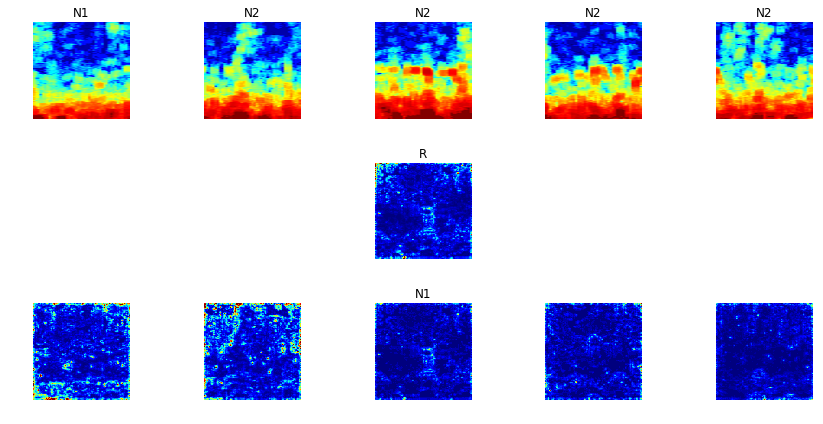

In [80]:
# jet
plotSaliency(954, cnn, lcrn, "saliency954_jet.png")

Real labels: [2 2 2 2 2]
CNN pred: 1
CRNN pred: 2


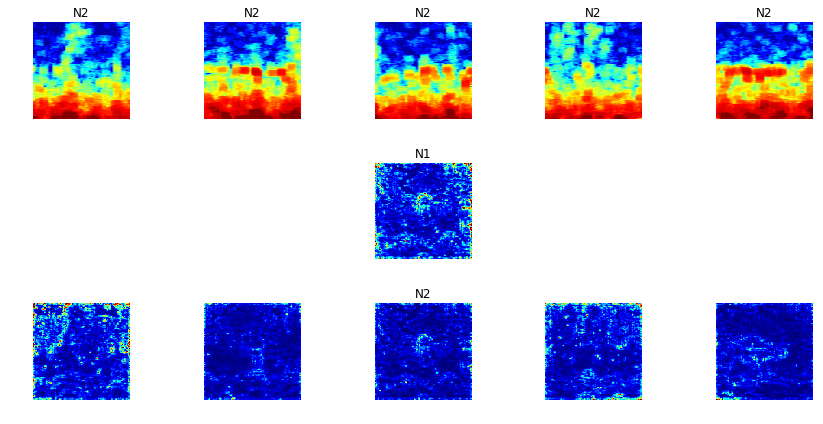

In [81]:
plotSaliency(955, cnn, lcrn, "saliency955_jet.png")

Real labels: [2 2 2 2 2]
CNN pred: 4
CRNN pred: 2


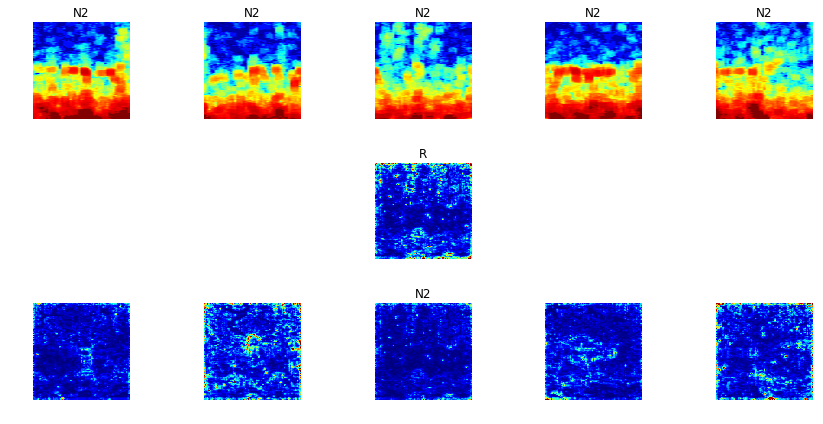

In [82]:
plotSaliency(956, cnn, lcrn, "saliency956_jet.png")

## CAM

In [27]:
# CNN
layer_idx = utils.find_layer_idx(cnn, 'Dense3')
penult_idx = utils.find_layer_idx(cnn, 'block5_pool')
cnn_cam = visualize_cam(cnn, layer_idx, filter_indices=4, seed_input=imgs[2],
                       backprop_modifier='guided', penultimate_layer_idx=penult_idx)

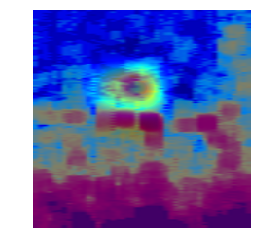

In [28]:
plt.imshow(overlay(cnn_cam, imgs[2]), cmap='jet')
plt.axis('Off')
plt.show()

Have to modify keras-vis for this. See: https://github.com/raghakot/keras-vis/pull/45/files

In [29]:
# RNN
layer_idx = utils.find_layer_idx(lcrn, 'block7_lstm3')
penult_idx = utils.find_layer_idx(lcrn, 'block5_tdist_pool')
# rnn_cam = visualize_cam_tdist(lcrn, layer_idx, filter_indices=1, seed_img=imgs[2],
#                        penultimate_layer_idx=penult_idx, input_data_rnn=imgs)

In [30]:
# plt.figure(figsize=(12,6))

# for idx, img in enumerate(imgs):
#     cam = visualize_cam(cnn, layer_idx, filter_indices=0, seed_input=img,
#                        backprop_modifier='guided', penultimate_layer_idx=penult_idx)
#     plt.subplot(1,2,idx+1)
#     plt.axis('Off')
#     plt.imshow(overlay(cam, img), cmap='jet')
# plt.tight_layout()

----

# Experimental per class saliency maps

Testing on CNN:
- Import CNN/RNN1/RNN5 models
- Load models with corresponding fold4 weights
- Load spectrograms and labels for test subjects (1 and 11)
- Feed images through models and fetch gradients with visualize_saliency
- Average visualize_saliency gradients for each model by target label
- Plot gradients

In [114]:
# # modify softmax to linear
# layer_idx = utils.find_layer_idx(cnn, 'Dense3')
# cnn.layers[layer_idx].activation = activations.linear
# cnn = utils.apply_modifications(cnn)

Compute gradients wrt input images

In [32]:
# compute gradients for test subjects:
# grads_unguided = []

# for img, tgt in zip(sub2_inputs[:10], sub2_targets[:10]):
#     grads_unguided.append(visualize_saliency(cnn, layer_idx, filter_indices=tgt, seed_input=img))
# print("Finished sub2!")

# for img, tgt in zip(sub11_inputs[:10], sub11_targets[:10]):
#     grads_unguided.append(visualize_saliency(cnn, layer_idx, filter_indices=tgt, seed_input=img))
# print("Finished sub11!")

In [140]:
# load precomputed gradients for subj2 and 11 (fold4 testsubs)
with open('/Users/anders1991/Desktop/CNN_grads_unguided.pickle', 'rb') as handle:
    CNN_grads = pickle.load(handle)
    
CNN_grads = np.array(CNN_grads)
targets = np.concatenate((sub2_targets, sub11_targets))
print(CNN_grads.shape)
print(targets.shape)

(4188, 224, 224, 3)
(4188,)


Bin gradients by class

In [141]:
W = []
N1 = []
N2 = []
N3 = []
R = []
missing = []

for grads, tgt in zip(CNN_grads, targets):
    if tgt == 0:
        W.append(grads)
    elif tgt == 1:
        N1.append(grads)
    elif tgt == 2:
        N2.append(grads)
    elif tgt == 3:
        N3.append(grads)
    elif tgt == 4:
        R.append(grads)
    else:
        missing.append((grads, tgt))

In [142]:
W = np.array(W, dtype=np.float32)
N1 = np.array(N1, dtype=np.float32)
N2 = np.array(N2, dtype=np.float32)
N3 = np.array(N3, dtype=np.float32)
R = np.array(R, dtype=np.float32)

In [143]:
saliency_W = np.mean(np.abs(W), axis=0)
saliency_N1 = np.mean(np.abs(N1), axis=0)
saliency_N2 = np.mean(np.abs(N2), axis=0)
saliency_N3 = np.mean(np.abs(N3), axis=0)
saliency_R = np.mean(np.abs(R), axis=0)

Normalize pixel values

In [144]:
from sklearn.preprocessing import normalize

def imgnorm(saliency):
    imgmin = saliency.min(axis=(0,1), keepdims=True)
    imgmax = saliency.max(axis=(0,1), keepdims=True)
    return (saliency - imgmin)/(imgmax - imgmin)

In [145]:
CNN_W = imgnorm(saliency_W)
CNN_N1 = imgnorm(saliency_N1)
CNN_N2 = imgnorm(saliency_N2)
CNN_N3 = imgnorm(saliency_N3)
CNN_R = imgnorm(saliency_R)

Plot average per class saliency maps

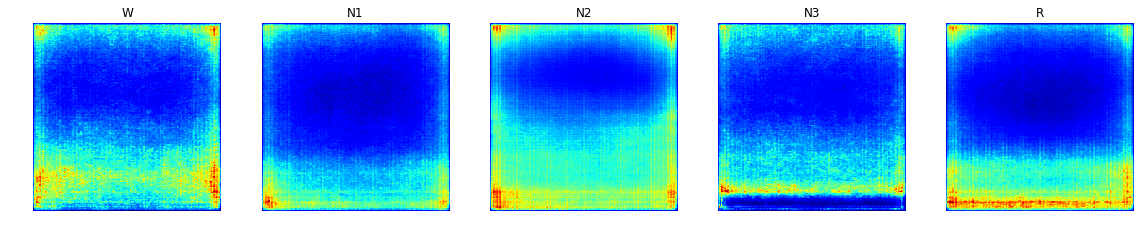

In [148]:
plt.figure(figsize=(16,10))

for idx, (img, title) in enumerate(zip([CNN_W, CNN_N1, CNN_N2, CNN_N3, CNN_R],
                                    ["W", "N1", "N2", "N3", "R"])):
    plt.subplot(1,5,idx+1)
    plt.imshow(np.mean(img, axis=2), cmap='jet')
    plt.axis('Off')
    plt.title(title)

plt.tight_layout()

----

# Keras-vis demo

/Users/anders1991/miniconda3/envs/py3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


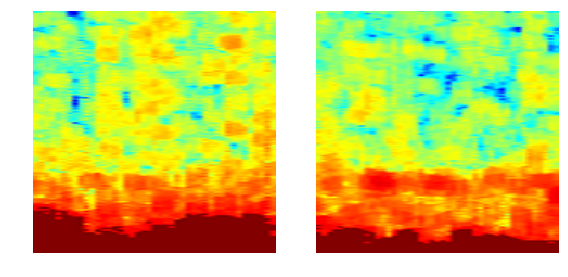

In [40]:
img1 = utils.load_img('../imdata/sub1_n1_img_fpz/img_1.png', target_size=(224,224))
img2 = utils.load_img('../imdata/sub1_n1_img_fpz/img_2.png', target_size=(224,224))
imgs = [img1, img2]

plt.figure(figsize=(8,4))
for idx, img in enumerate(imgs):    
    plt.subplot(1,2,idx+1)
    plt.axis('Off')
    plt.imshow(img)
plt.tight_layout()

## Saliency

Vanilla

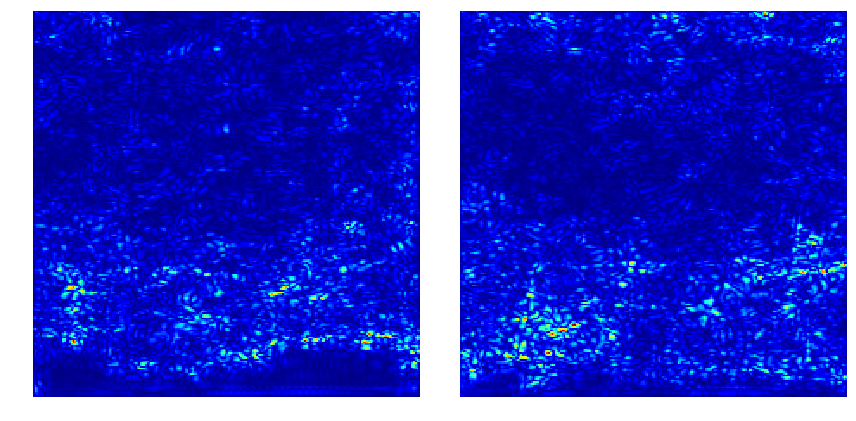

In [41]:
layer_idx = utils.find_layer_idx(cnn, 'Dense3')

plt.figure(figsize=(12,6))
for idx, img in enumerate(imgs):    
    grads = visualize_saliency(cnn, layer_idx, filter_indices=0, 
                               seed_input=img)
    plt.subplot(1,2,idx+1)
    plt.axis('Off')
    plt.imshow(grads, cmap='jet')
# plt.suptitle("Saliency maps", y=1.05, fontsize=16)
plt.tight_layout()

Guided

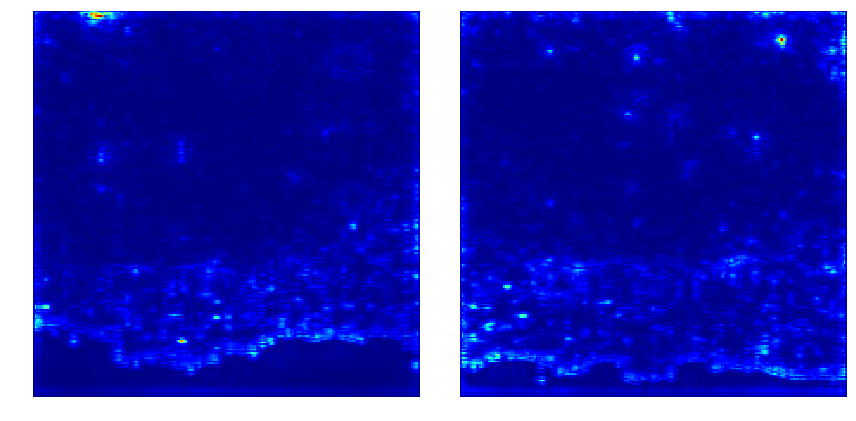

In [42]:
plt.figure(figsize=(12,6))

for idx, img in enumerate(imgs):
    grads = visualize_saliency(cnn, layer_idx, filter_indices=0, 
                               seed_input=img, backprop_modifier='guided')
    plt.subplot(1,2,idx+1)
    plt.axis('Off')
    plt.imshow(grads, cmap='jet')
plt.tight_layout()

## CAM

In [43]:
layer_idx = utils.find_layer_idx(cnn, 'Dense3')
penult_idx = utils.find_layer_idx(cnn, 'block5_pool')

Vanilla

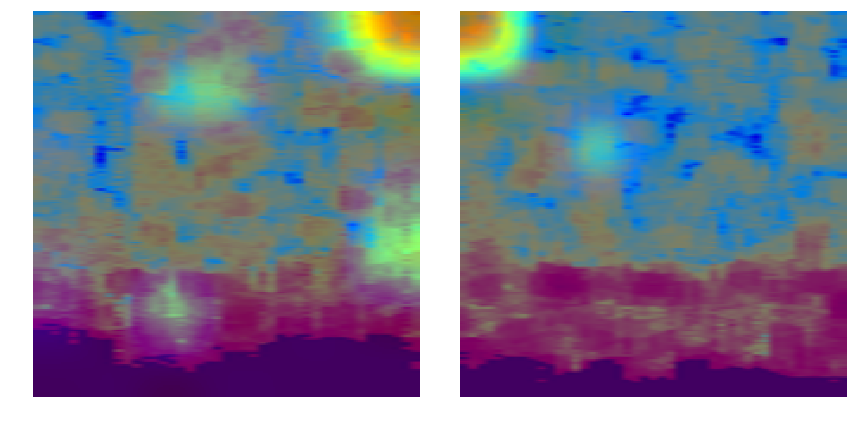

In [44]:
plt.figure(figsize=(12,6))

for idx, img in enumerate(imgs):
    cam = visualize_cam(cnn, layer_idx, filter_indices=0, seed_input=img,
                       backprop_modifier=None, penultimate_layer_idx=penult_idx)
    plt.subplot(1,2,idx+1)
    plt.axis('Off')
    plt.imshow(overlay(cam, img), cmap='jet')
plt.tight_layout()

RELU

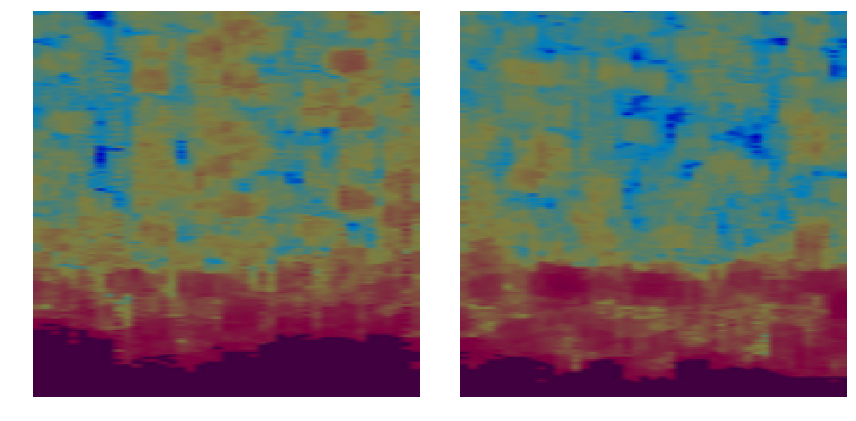

In [45]:
plt.figure(figsize=(12,6))

for idx, img in enumerate(imgs):
    cam = visualize_cam(cnn, layer_idx, filter_indices=0, seed_input=img,
                       backprop_modifier='relu', penultimate_layer_idx=penult_idx)
    plt.subplot(1,2,idx+1)
    plt.axis('Off')
    plt.imshow(overlay(cam, img), cmap='jet')
plt.tight_layout()

Guided

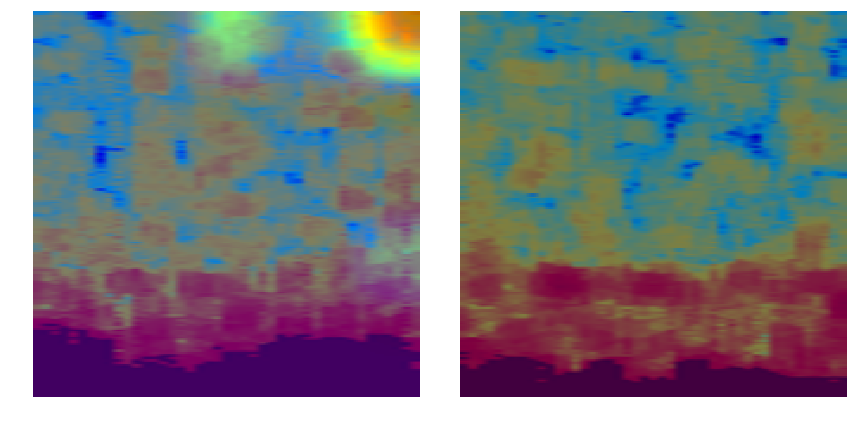

In [46]:
plt.figure(figsize=(12,6))

for idx, img in enumerate(imgs):
    cam = visualize_cam(cnn, layer_idx, filter_indices=0, seed_input=img,
                       backprop_modifier='guided', penultimate_layer_idx=penult_idx)
    plt.subplot(1,2,idx+1)
    plt.axis('Off')
    plt.imshow(overlay(cam, img), cmap='jet')
plt.tight_layout()

----